## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [1]:
import torch  # Импорт основную библиотеку PyTorch для работы с нейронными сетями
from tqdm import tqdm  # Импорти tqdm для отображения прогресс-баров
import torch.nn as nn  # Импорт модуля nn для создания слоев нейронной сети
import torch.optim as optim  # Импорт модуль оптимизации
import torchvision  # Импорт torchvision для работы с изображениями и датасетами
import torchvision.transforms as transforms  # Импорт трансформации для обработки изображений
import matplotlib.pyplot as plt  # Импорт matplotlib для визуализации данных
import numpy as np  # Импортир NumPy для работы с массивами
from sklearn.model_selection import train_test_split  # Импорт функцию для разделения данных на обучающие и тестовые наборы

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [2]:
# Установка устройства (GPU или CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Проверяем, доступен ли GPU, иначе используем CPU
print(f'Running on {device}')  # Вывод, на каком устройстве будет выполняться код

Running on cpu


In [3]:
# Функция для подсчета числа параметров в модели
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)  # Считаем количество обучаемых параметров модели

# Определение класса модели
class Baseline(nn.Module):
    def __init__(self, num_classes=10):  # Конструктор класса, принимающий количество классов
        super(Baseline, self).__init__()  # Инициализация базового класса nn.Module
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # Первый сверточный слой
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # Второй сверточный слой
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)  # Первый полносвязный слой
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)  # Второй полносвязный слой, выходной слой

    def forward(self, x):  # Метод для прямого прохода через сеть
        # Прямой проход через сверточные слои с активацией ReLU
        x = torch.relu(self.conv1(x))  # Применяем ReLU к первому сверточному слою
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  # Применяем максимальную пулинг-операцию
        x = torch.relu(self.conv2(x))  # Применяем ReLU ко второму сверточному слою
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  # Применяем максимальную пулинг-операцию
        # Вытягивание в одномерный вектор для полносвязных слоев
        x = x.view(x.size(0), -1)  # Изменяем размерность тензора
        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))  # Применяем ReLU к первому полносвязному слою
        x = self.fc2(x)  # Проход через выходной слой
        return x  # Возвращаем выходные данные

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170M/170M [00:29<00:00, 5.82MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


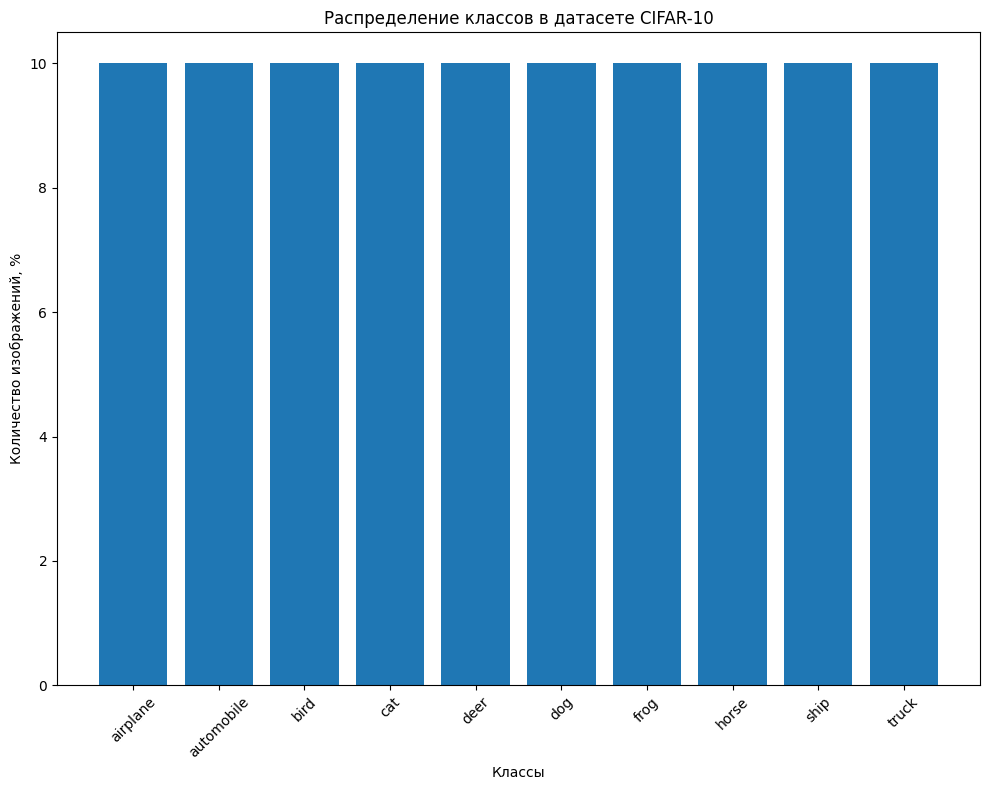

In [4]:
# Преобразование изображений в формат torch.Tensor
transform = transforms.ToTensor()  # Преобразование изображений в тензоры

# Загрузка датасетов для обучения и тестирования
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)  # Загрузка обучающего датасета CIFAR-10
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)  # Загрузка тестового датасета CIFAR-10

# Получение меток классов
class_labels = train_dataset.classes  # Получаем названия классов
class_counts = np.array([0] * len(class_labels))  # Инициализируем массив для подсчета количества изображений в каждом классе

# Подсчет количества изображений в каждом классе
for _, label in train_dataset:  # Проходим по всему обучающему датасету
    class_counts[label] += 1  # Увеличиваем счетчик для соответствующего класса

class_counts = class_counts / class_counts.sum() * 100  # Преобразуем в процентное соотношение

# Построение диаграммы распределения классов
plt.figure(figsize=(10, 8))  # Устанавливаем размер фигуры для графика
plt.bar(class_labels, class_counts)  # Строим столбчатую диаграмму
plt.xlabel('Классы')  # Подпись оси X
plt.ylabel('Количество изображений, %')  # Подпись оси Y
plt.title('Распределение классов в датасете CIFAR-10')  # Заголовок графика
plt.xticks(rotation=45)  # Поворачиваем метки по оси X для удобства чтения
plt.tight_layout()  # Автоматически подгоняем параметры графика
plt.show()  # Отображаем график

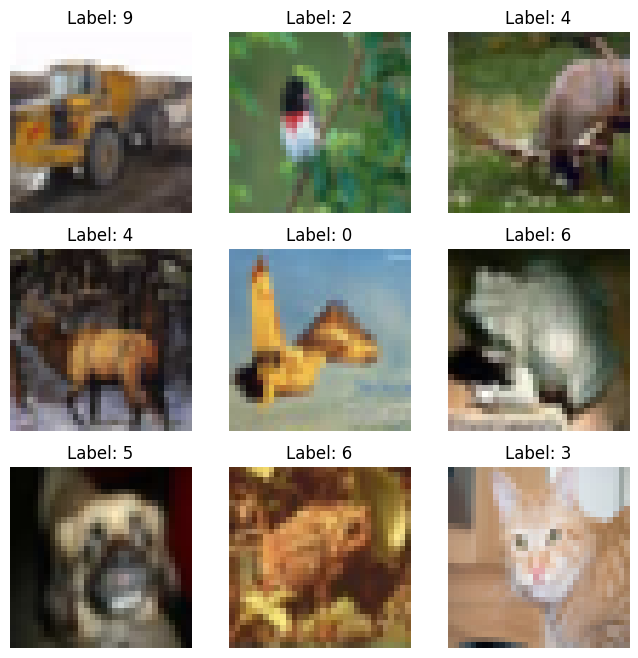

Model params:  268650


In [5]:
# Отображение случайных изображений из обучающего датасета
indices = np.random.choice(len(train_dataset), 9, replace=False)  # Выбор 9 случайных индексов
fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Создаем сетку для отображения изображений
for i, ax in enumerate(axes.flat):  # Проходим по всем осям в сетке
    image, label = train_dataset[indices[i]]  # Получаем изображение и метку по индексу
    image = image.numpy().transpose((1, 2, 0))  # Переводим изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)  # Отображаем изображение
    ax.set_title(f'Label: {label}')  # Устанавливаем заголовок с меткой класса
    ax.axis('off')  # Отключаем оси для лучшего отображения
plt.show()  # Отображаем изображения

# Разделение на обучающую и валидационную выборки
train_size = int(0.8 * len(train_dataset))  # Определяем размер обучающего набора (80%)
val_size = len(train_dataset) - train_size  # Определяем размер валидационного набора
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)  # Разделяем данные на обучающую и валидационную выборки

# Создание DataLoader'ов для загрузки данных
batch_size = 64  # Устанавливаем размер пакета
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Создание DataLoader для обучающего набора
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)  # Создание DataLoader для валидационного набора
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Создание DataLoader для тестового набора

# Гиперпараметры
learning_rate = 0.001  # Устанавливаем скорость обучения
num_epochs = 10  # Устанавливаем количество эпох для обучения
model = Baseline().to(device)  # Создаем экземпляр модели и переносим ее на устройство (GPU или CPU)
print('Model params: ', count_parameters(model))  # Выводим количество параметров модели

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()  # Используем функцию потерь кросс-энтропии для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Используем оптимизатор Adam


Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [6]:
# Функция для обучения модели
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()  # Устанавливаем модель в режим обучения
    train_loss_history = []  # Список для хранения истории потерь на обучающем наборе
    train_acc_history = []  # Список для хранения истории точности на обучающем наборе
    val_loss_history = []  # Список для хранения истории потерь на валидационном наборе
    val_acc_history = []  # Список для хранения истории точности на валидационном наборе
    
    for epoch in range(epochs):  # Проходим по эпохам
        running_loss = 0.0  # Инициализируем переменную для накопления потерь
        correct = 0  # Инициализируем счетчик правильных предсказаний
        total = 0  # Инициализируем общий счетчик
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))  # Создание прогресс-бар для обучения
        
        for batch_idx, (inputs, labels) in pbar:  # Проходим по пакетам данных
            inputs, labels = inputs.to(device), labels.to(device)  # Переносим данные на устройство
            optimizer.zero_grad()  # Зануляем градиенты для оптимизатора
            outputs = model(inputs)  # Получаем предсказания модели
            loss = criterion(outputs, labels)  # Вычисляем потери
            
            loss.backward()  # Обратный проход для вычисления градиентов
            optimizer.step()  # Шаг оптимизации
            
            running_loss += loss.item()  # Накопление потерь
            _, predicted = torch.max(outputs.data, 1)  # Получаем предсказанные классы
            total += labels.size(0)  # Обновляем общий счетчик
            correct += (predicted == labels).sum().item()  # Обновляем счетчик правильных предсказаний
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})  # Обновляем прогресс-бар с потерями и точностью
        
        train_loss_history.append(running_loss / len(train_loader))  # Сохраняем средние потери на обучающем наборе
        train_acc_history.append(correct / total)  # Сохраняем точность на обучающем наборе

        # Валидация
        correct = 0  # Счетчик для правильных предсказаний на валидационном наборе
        total = 0  # Общий счетчик на валидационном наборе
        test_loss = 0.0  # Инициализируем переменную для накопления потерь на валидационном наборе
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))  # Создаем прогресс-бар для валидации
        
        with torch.no_grad():  # Отключаем градиенты для валидации
            for batch_idx, (inputs, labels) in pbar:  # Проходим по пакетам валидационных данных
                inputs, labels = inputs.to(device), labels.to(device)  # Переносим данные на устройство
                outputs = model(inputs)  # Получаем предсказания модели
                loss = criterion(outputs, labels)  # Вычисляем потери
                test_loss += loss.item()  # Накопление потерь
                _, predicted = torch.max(outputs.data, 1)  # Получаем предсказанные классы
                total += labels.size(0)  # Обновляем общий счетчик
                correct += (predicted == labels).sum().item()  # Обновляем счетчик правильных предсказаний
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})  # Обновляем прогресс-бар
        
        val_loss_history.append(test_loss / len(val_loader))  # Сохраняем средние потери на валидационном наборе
        val_acc_history.append(correct / total)  # Сохраняем точность на валидационном наборе
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history  # Возвращаем историю потерь и точности

# Функция для тестирования модели
def test(model, test_loader, criterion, device):
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0  # Счетчик для правильных предсказаний
    total = 0  # Общий счетчик
    test_loss = 0.0  # Инициализация переменную для накопления потерь
    with torch.no_grad():  # Отключаем градиенты для тестирования
        for inputs, labels in test_loader:  # Проходим по тестовым данным
            inputs, labels = inputs.to(device), labels.to(device)  # Переносим данные на устройство
            outputs = model(inputs)  # Получаем предсказания модели
            loss = criterion(outputs, labels)  # Вычисляем потери
            test_loss += loss.item()  # Накопление потерь
            _, predicted = torch.max(outputs.data, 1)  # Получаем предсказанные классы
            total += labels.size(0)  # Обновляем общий счетчик
            correct += (predicted == labels).sum().item()  # Обновляем счетчик правильных предсказаний

    accuracy = correct / total  # Вычисление точности
    average_loss = test_loss / len(test_loader)  # Вычисляем средние потери
    
    return accuracy, average_loss  # Возвращаем точность и средние потери

            
    

Сделайте разделение на train и val
\
Зачем так делать?

In [7]:
# Обучение модели
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)


Val 10/10: 100%|███████████████████| 157/157 [00:01<00:00, 141.82it/s, loss=0.9564, accuracy=0.6741]


Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

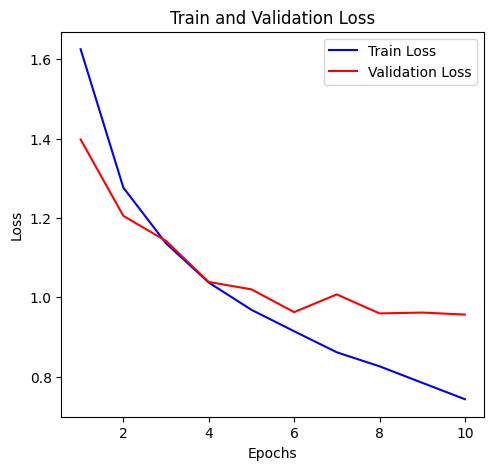

In [8]:
# Графики обучения
epochs = range(1, len(train_loss_history) + 1)  # Создаем диапазон для оси X

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))  # Устанавливаем размер графика
plt.subplot(1, 2, 1)  # Создаем подграфик для потерь
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')  # График потерь на обучающем наборе
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')  # График потерь на валидационном наборе
plt.title('Train and Validation Loss')  # Заголовок графика
plt.xlabel('Epochs')  # Подпись оси X
plt.ylabel('Loss')  # Подпись оси Y
plt.legend()  # Отображаем легенду

Обучите модель и постройте графики обучения

In [9]:
# Оценка тестовой метрики на тестовых данных
test_acc, test_loss = test(model, test_loader, criterion, device)  # Тестируем модель на тестовом наборе

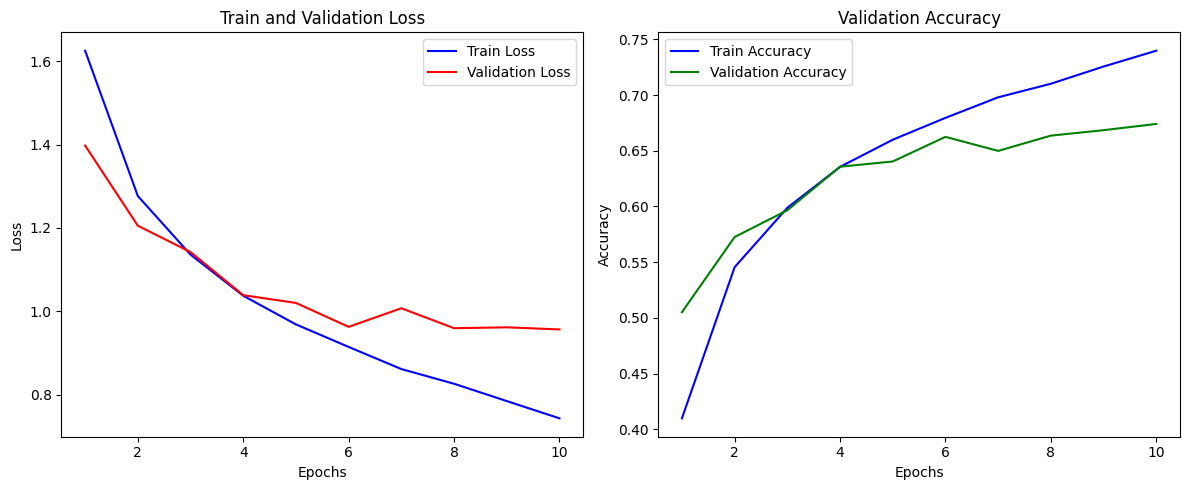

In [10]:
# Графики обучения
epochs = range(1, len(train_loss_history) + 1)  # Создаем диапазон для оси X

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))  # Устанавливаем размер графика
plt.subplot(1, 2, 1)  # Создаем подграфик для потерь
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')  # График потерь на обучающем наборе
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')  # График потерь на валидационном наборе
plt.title('Train and Validation Loss')  # Заголовок графика
plt.xlabel('Epochs')  # Подпись оси X
plt.ylabel('Loss')  # Подпись оси Y
plt.legend()  # Отображаем легенду

# График точности на валидационных данных
plt.subplot(1, 2, 2)  # Создаем подграфик для точности
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')  # График точности на обучающем наборе
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')  # График точности на валидационном наборе
plt.title('Validation Accuracy')  # Заголовок графика
plt.xlabel('Epochs')  # Подпись оси X
plt.ylabel('Accuracy')  # Подпись оси Y
plt.legend()  # Отображаем легенду

plt.tight_layout()  # Автоматически подгоняем параметры графиков
plt.show()  # Отображаем графики


Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [12]:
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_acc, test_loss))  # Вывод потерь и точности на тестовом наборе


Test Loss: 0.6649
Test Accuracy: 0.9759


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов